## **주요 개념 정리**
- **입력이나 필터의 차원이 몇 개인지에는 상관 없이 필터가 몇 개인지에 따라 출력값의 두께(특성 맵의 개수)가 정해지고, 필터가 (n,n,k)라도 출력으로는 하나의 값만이 출력된다.**

- 케라스의 합성곱 층은 항상 3차원의 입력(data의 개수 차원을 제외)을 기대한다.
- 입력 이미지는 항상 깊이(채널) 차원이 있어야 한다.
- train_input.reshape(-1,28,28,1) => 28x28의 각 사진 데이터에 1이라는 두께가 생겨서, 4차원이 되었다.

----
#### **Early Stopping Callback & Model Checkpoint**
```python
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True)
history = model.fit(train_scaled, train_target, epochs = 20, validation_data = (val_scaled, val_target), callbacks = [checkpoint_cb, early_stopping_cb])
```
- save_best_only = True와 restore_best_weights = True를 해줌으로,
- model = keras.models.load_model('best_model.h5')
- 이렇게 최상의 검증 점수를 낸 모델을 저장하고 load_model() 메서드로 다시 불러오지 않고, 바로 fit된 모델에 validation set을 평가할 수 있게 모델의 가중치가 최적의 가중치로 다시 변경되어 저장되어 있다.

> ModelCheckpoint 콜백에서 save_best_only=True를 사용하면 모델이 각 epoch에서 검증 손실이 감소할 때만 모델이 저장됩니다. 즉, 현재 epoch에서의 모델 상태가 이전 epoch보다 더 나아졌을 때만 저장됩니다.

> EarlyStopping 콜백에서 restore_best_weights=True를 설정하면 훈련이 조기 종료될 때 최적의 검증 손실을 갖는 epoch에서의 모델 가중치로 복원됩니다. 이는 훈련이 최적의 성능을 나타낼 때까지 진행한 다음, 성능이 더 이상 향상되지 않을 때 최적의 모델 상태로 복구시키는 데 사용됩니다.

## **Slicing VS Indexing 입력값 전달의 차이**
- 케라스의 fit(), predict(), evaluate()는 모두 입력의 첫 번째 차원이 배치 차원일 것으로 기대해서 슬라이싱으로 값을 전달하지 않고 인덱싱으로 전달을 해주면, 전달해주려는 data의 전체 차원이 유지되지 않는다.
- val_scaled[0] => (28,28,1)
- val_scaled[0:1] => (1,28,28,1) : 전체 차원이 유지됨

- fit(), predict(), evaluate()는 주로 넘파이(NumPy) 배열을 사용하여 데이터를 다루는데, 이 때 데이터의 첫 번째 차원이 배치 차원(batch dimension)이어야 합니다.

- **일반적으로, 넘파이 배열의 shape은 (배치 크기, 데이터 차원1, 데이터 차원2, ...)과 같은 형태를 가지며, 여기서 첫 번째 차원이 바로 배치 차원입니다.**

> #### **Batch Dimension**
"Batch dimension(배치 차원)"은 모델에 한 번에 입력되는 데이터의 묶음을 나타냅니다. **각각의 데이터 포인트는 하나의 샘플이고, 이러한 샘플들을 묶어서(batch)** 모델에 동시에 입력함으로써 학습 및 예측을 수행합니다. 일반적으로 데이터는 다차원 배열로 표현되는데, **이 중에서 첫 번째 차원이 바로 배치 차원**입니다. 배치 차원의 크기는 한 번에 모델에 전달되는 데이터 샘플의 개수를 나타냅니다. 예를 들어, 데이터의 shape이 (batch_size, features)인 경우, batch_size가 배치 차원이 되며, 각각의 데이터 포인트는 features 차원으로 표현됩니다.

#### **numpy 형태**
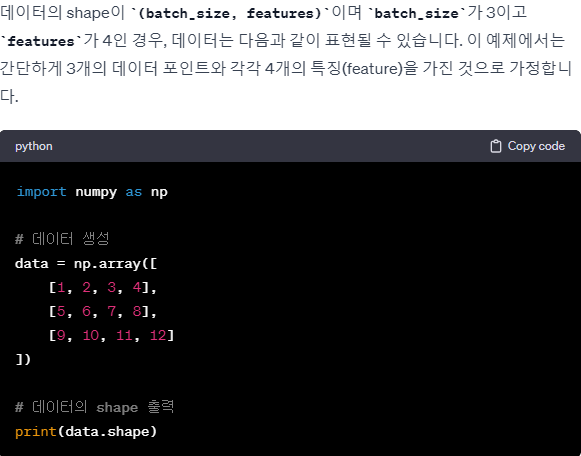

#### **텐서 형태**
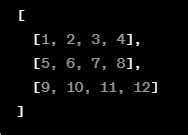

> **텐서 형태란?**
다차원 배열로, 선형 대수 연산에서 여러 종류의 수치 데이터를 표현하는 데 사용, 텐서의 차원(Dimension)을 랭크(Rank)라고 부르며, 각 차원의 크기를 축(Axis)이라고 합니다.



In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size = 0.2, random_state = 42)

4422102/4422102 [==============================] - 0s 0us/step


In [2]:
model = keras.Sequential()
# 합성곱 - 풀링층 1
model.add(keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = (28,28,1)))
model.add(keras.layers.MaxPooling2D(2))
# 합성곱 - 풀링층 2
model.add(keras.layers.Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.MaxPooling2D(2))
# 3차원 특성 맵 -> 일렬로 펼치기 : 마지막에 n개의 뉴런을 가진 출력층(밀집층)에서 확률을 계산하기 때문
# 바로 출력층으로 전달하지 않고, flatten 클래스 다음 dense ->drop out -> dense -> 출력층 순으로!
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation = 'relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

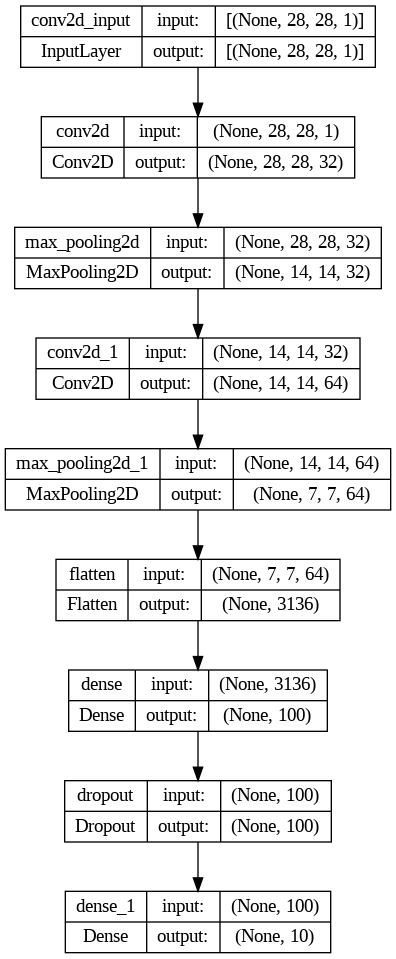

In [4]:
keras.utils.plot_model(model, show_shapes = True)

In [5]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True)
history = model.fit(train_scaled, train_target, epochs = 20, validation_data = (val_scaled, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 25s 6ms/step - loss: 0.5112 - accuracy: 0.8175 - val_loss: 0.3241 - val_accuracy: 0.8821
Epoch 2/20
  27/1500 [..............................] - ETA: 5s - loss: 0.3475 - accuracy: 0.8727

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 [==============================] - 7s 5ms/step - loss: 0.3386 - accuracy: 0.8792 - val_loss: 0.2857 - val_accuracy: 0.8938
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2880 - accuracy: 0.8967 - val_loss: 0.2551 - val_accuracy: 0.9053
Epoch 4/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2617 - accuracy: 0.9050 - val_loss: 0.2513 - val_accuracy: 0.9054
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2357 - accuracy: 0.9145 - val_loss: 0.2253 - val_accuracy: 0.9180
Epoch 6/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2152 - accuracy: 0.9193 - val_loss: 0.2249 - val_accuracy: 0.9190
Epoch 7/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1990 - accuracy: 0.9261 - val_loss: 0.2352 - val_accuracy: 0.9145
Epoch 8/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1859 - accuracy: 0.9309 - val_loss: 0.2286 - val_accuracy: 0.9200


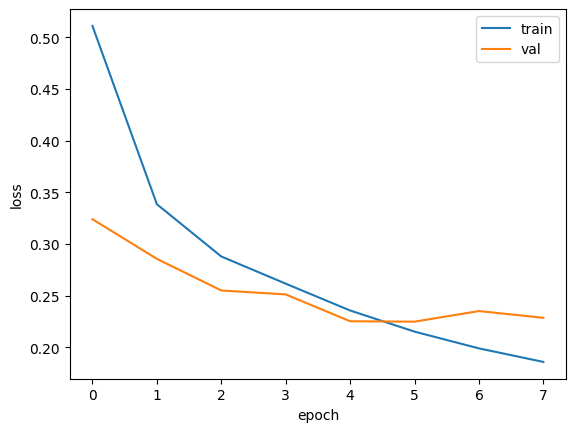

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [7]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.2249 - accuracy: 0.9190


[0.22488336265087128, 0.9190000295639038]

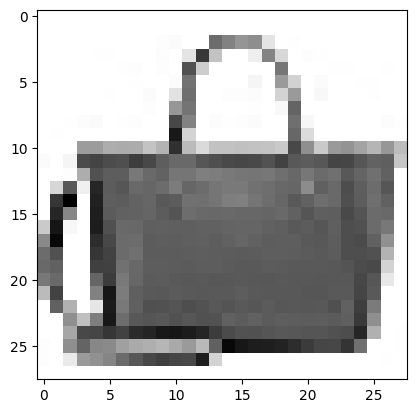

In [8]:
plt.imshow(val_scaled[0].reshape(28,28), cmap = 'gray_r')
plt.show()

In [14]:
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 [==============================] - 0s 67ms/step
[[1.3294778e-15 2.0211670e-21 1.9274152e-18 1.4287924e-17 8.3278709e-19
  2.9884237e-14 1.2588203e-15 1.7154979e-15 1.0000000e+00 2.6894327e-15]]


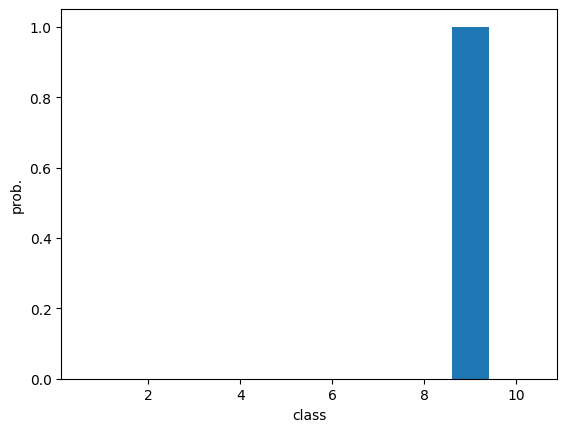

In [15]:
plt.bar(range(1,11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [16]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트','샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [17]:
import numpy as np
print(classes[np.argmax(preds)])

가방


In [18]:
test_scaled = test_input.reshape(-1,28,28,1)/255.0

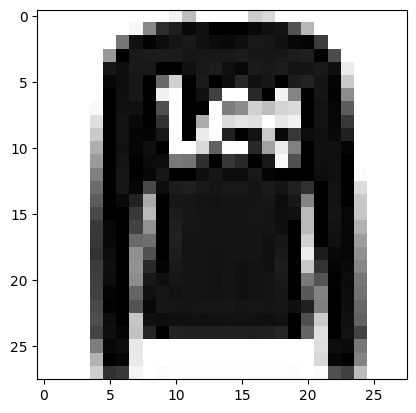

In [19]:
plt.imshow(test_scaled[1],cmap = 'gray_r')
plt.show()

In [20]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 3ms/step - loss: 0.2424 - accuracy: 0.9093


[0.24237549304962158, 0.9093000292778015]

In [22]:
k = model.predict(test_scaled[1:2])

1/1 [==============================] - 0s 21ms/step


In [23]:
print(classes[np.argmax(k)])

스웨터
